#### Loading packages

In [490]:
import torch
from astropy.io import fits
import glob
import numpy as np
import pandas as pd

In [491]:
if (torch.cuda.is_available()):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

# intel HD does not support CUDA

cpu


In [492]:
# classical approach to compare with ANN
def rolo_b_me(alpha, emission, incidence):
    '''
    Here we obtain the reflectance for any photometric angle (using degrees as input)  
    according to our classic photometric modeling. This model consists of the Sommel-Seeliger 
    disk function and ROLO as a phase function.

    Use example: for phase=30º, emission=0º and incidence=30º - ipwg(30, 0, 30)
    
    Inputs: phase, emission and incidence angles
    Output: reflectance
    '''
    # parameters
    C_0, C_1, A_0, A_1, A_2, A_3, A_4=np.loadtxt('parameters.txt')  
    
    # converting degrees to radians:
    emission=np.deg2rad(emission)    
    incidence=np.deg2rad(incidence)
    
    # computing reflectance according to this photometric model:
    disk = (np.cos(incidence)/(np.cos(incidence)+np.cos(emission)))
    phase = C_0*np.exp(-C_1*alpha) + A_0 + A_1*alpha + A_2*(alpha)**2 + A_3*(alpha)**3  + A_4*(alpha)**4 
    
    reflectance = disk * phase
    
    return reflectance

In [493]:
def data_preparation(ID):
    '''
     Here we extract features and labels using the ID of each image.
    Later we convert these data in the apropiate format for training or validation.
    It calls to data_normalization() function.
    '''
    
    iof_n, phase_n, emission_n, incidence_n = data_normalization(ID)
    
    
    # packing data
    features = np.zeros((len(phase_n),3)) 
    features[:,0] = phase_n
    features[:,1] = emission_n
    features[:,2] = incidence_n
    
    features = torch.FloatTensor(features)
    features = features.to(device)
    
    labels = np.zeros((len(iof_n),1))
    labels[:,0] = iof_n
    
    labels = torch.FloatTensor(labels)
    labels = labels.to(device)
    
    return features, labels

In [494]:
def data_normalization(ID):
    '''
    In this function we rescale data between 0 and 1, a very important step before trainning a neural network.
    It calls to loading_and_cleaning_data() function.
    '''
    iof_, phase_, emission_, incidence_ = loading_and_cleaning_data(ID)
       
    #normalizing data
    iof_n=iof_/0.06; phase_n=phase_/90; emission_n=emission_/82; incidence_n=incidence_/82

    return iof_n, phase_n, emission_n, incidence_n

In [495]:
def loading_and_cleaning_data(ID):
    '''
    This function is for loading iof, phase, emission, incidence values for each image. 
    '''
    #criterion for removing data:
    em, eM = (0, 82)        # emission limits  
    im, iM = (0, 82)          # incidence limits
    pm, pM = (0, 90)       # phase limits
    rm, rM =  (0.001,1)  # reflectance higher limits
    
    fits_file = fits.getdata(ID, ignore_missing_end=True)
    
    iof = fits_file[0]
    phase = fits_file[1]
    emission = fits_file[2]
    incidence = fits_file[3]
    
    idxsort = (emission >= em) & (emission <= eM) & \
              (incidence >= im) & (incidence <= iM) & \
              (phase >= pm) & (phase <= pM) & \
              (iof >= rm) & (iof <= rM) 
    
    return iof[idxsort], phase[idxsort], emission[idxsort], incidence[idxsort] 

In [496]:
# loading ID list of files:
files_ID=[]
for i in sorted(glob.glob('reduced_phocubes/*reduce.fits')):
    files_ID.append(i)

In [497]:
len(files_ID)

951

#### Preparing training and validation data

In [498]:
import random
# defining global tensors 

final_training_features = torch.zeros(0)
final_training_labels = torch.zeros(0)
final_validation_features = torch.zeros(0)
final_validation_labels = torch.zeros(0)

final_training_features = final_training_features.to(device)
final_training_labels = final_training_labels.to(device)
final_validation_features = final_validation_features.to(device)
final_validation_labels = final_validation_labels.to(device)

for file in files_ID:
    
    # loading training data from files_ID list
    _features, _labels = data_preparation(file)
    if len(_features) != 0:
        np.random.seed(10)
        # Selecting 1000 random values of this image
        try:
            mask_temp = np.random.choice(len(_features),1000,replace=False)
        
        except:
            mask_temp = np.random.choice(len(_features),len(_features),replace=False)
        
        split = int(len(mask_temp)*(9/10))
        mask_train = mask_temp[0:split]
        mask_val = mask_temp[split:]
        
        training_features =  _features[mask_train]
        final_training_features = torch.cat([final_training_features,training_features])
        
        training_labels = _labels[mask_train]
        final_training_labels = torch.cat([final_training_labels,training_labels])

        validation_features =  _features[mask_val]
        final_validation_features=torch.cat([final_validation_features,validation_features])

        validation_labels = _labels[mask_val]
        final_validation_labels=torch.cat([final_validation_labels,validation_labels])

#### ROLO eficciency using MSE:

In [499]:
#ROLO eficciency using MSE:
phase=final_validation_features.cpu().numpy()[:,0]*90
emission=final_validation_features.cpu().numpy()[:,1]*82
incidence=final_validation_features.cpu().numpy()[:,2]*82
prediction_ROLO=torch.tensor(rolo_b_me(phase, emission, incidence)/0.06).to(device)
eff_ROLO=torch.mean((prediction_ROLO-final_validation_labels.t())**2)
print(eff_ROLO)

tensor(0.0044)


In [500]:
print(len(final_training_features), len(final_validation_features))
final_training_features = final_training_features.numpy()
final_validation_features = final_validation_features.numpy()

417025 46480


In [501]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score ,recall_score
from tensorflow.keras import layers,losses
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError

tf.random.set_seed(1)

class Autoencoder(Model):
    def __init__(self,latent_dim=9):
        super(Autoencoder,self).__init__()
        self.latent_dim=9
        self.encoder=tf.keras.Sequential([
            layers.Dense(64,activation="relu"),
            layers.Dense(64,activation="relu"),
            layers.Dense(latent_dim,activation="relu")])
        
        self.decoder=tf.keras.Sequential([
            layers.Dense(64,activation="relu"),
            layers.Dense(64,activation="relu"),
            layers.Dense(3,activation="sigmoid")])
        
    def call(self,x):
        encoded=self.encoder(x)
        decoded=self.decoder(encoded)
        return decoded

autoencoder=Autoencoder()
autoencoder.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
autoencoder.fit(final_training_features,final_training_features, 
                validation_data=(final_validation_features, final_validation_features), epochs=20, batch_size=1000)

autoencoder.summary()


Epoch 1/20
418/418 [==============================] - 2s 4ms/step - loss: 0.0088 - accuracy: 0.8435 - val_loss: 2.6698e-04 - val_accuracy: 0.9718
Epoch 2/20
418/418 [==============================] - 2s 4ms/step - loss: 1.5683e-04 - accuracy: 0.9758 - val_loss: 1.0369e-04 - val_accuracy: 0.9826
Epoch 3/20
418/418 [==============================] - 2s 4ms/step - loss: 6.4331e-05 - accuracy: 0.9816 - val_loss: 5.0152e-05 - val_accuracy: 0.9750
Epoch 4/20
418/418 [==============================] - 2s 4ms/step - loss: 4.3965e-05 - accuracy: 0.9809 - val_loss: 3.7072e-05 - val_accuracy: 0.9818
Epoch 5/20
418/418 [==============================] - 2s 4ms/step - loss: 3.5506e-05 - accuracy: 0.9818 - val_loss: 3.0966e-05 - val_accuracy: 0.9823
Epoch 6/20
418/418 [==============================] - 2s 5ms/step - loss: 3.0876e-05 - accuracy: 0.9813 - val_loss: 4.5476e-05 - val_accuracy: 0.9540
Epoch 7/20
418/418 [==============================] - 2s 5ms/step - loss: 2.7086e-05 - accuracy: 0.9820 

In [502]:
x_training_encoded = autoencoder.encoder(final_training_features).numpy()
x_vaidation_encoded = autoencoder.encoder(final_validation_features).numpy()

print(x_training_encoded.shape)
print(x_vaidation_encoded.shape)

import numpy as np
x_training_concat = np.concatenate((final_training_features, x_training_encoded), axis = 1)
x_validation_concat = np.concatenate((final_validation_features, x_vaidation_encoded), axis = 1)

print(x_training_concat.shape)
print(x_validation_concat.shape)


(417025, 9)
(46480, 9)
(417025, 12)
(46480, 12)


In [503]:
def correlated_features(data,threshold):
    corr_col=set()
    confusion=data.corr()
    for i in range(confusion.shape[0]):
        for j in range(i): 
             if confusion.iloc[i,j]>threshold:
                    corr_col.add(confusion.columns[i])
    return corr_col

pd_x_training_concat = pd.DataFrame (x_training_concat)
pd_x_validation_concat = pd.DataFrame (x_validation_concat)

corr_features= correlated_features(pd_x_training_concat , 0.9)
print(len(corr_features))

x_training_corr = pd_x_training_concat.drop(corr_features,axis=1)
x_validation_corr = pd_x_validation_concat.drop(corr_features,axis=1)

2


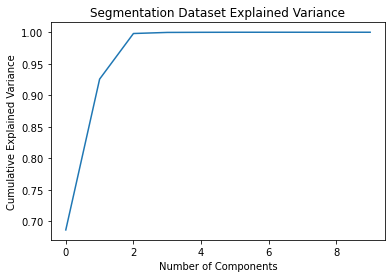

In [504]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA()
pca.fit(x_training_corr)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')  
plt.title('Segmentation Dataset Explained Variance')
plt.show(block=True)

In [505]:
pca = PCA(n_components=3)
x_training_pca = pca.fit_transform(x_training_corr)
x_validation_pca = pca.fit_transform(x_validation_corr)
print(x_training_pca.shape)

(417025, 3)


In [506]:
final_training_features = torch.from_numpy(x_training_pca)
final_validation_features = torch.from_numpy(x_validation_pca)

3


#### Setting up and defining a neural network

In [514]:
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_sizes, n_output):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_sizes[0])
        torch.nn.init.kaiming_normal_(self.fc1.weight) 
        self.fc2 = torch.nn.Linear(hidden_sizes[0], hidden_sizes[1])
        torch.nn.init.kaiming_normal_(self.fc2.weight)
        self.fc3 = torch.nn.Linear(hidden_sizes[1], hidden_sizes[2])
        torch.nn.init.kaiming_normal_(self.fc3.weight)
        self.fc4 = torch.nn.Linear(hidden_sizes[2], hidden_sizes[3])
        torch.nn.init.kaiming_normal_(self.fc4.weight)
        self.fc5 = torch.nn.Linear(hidden_sizes[3], hidden_sizes[4])
        torch.nn.init.kaiming_normal_(self.fc5.weight)
        self.fc6 = torch.nn.Linear(hidden_sizes[4], n_output)
        torch.nn.init.kaiming_normal_(self.fc6.weight)
        self.relu = torch.nn.ELU()
        self.sigmoid = torch.nn.Sigmoid() 
        
  
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.relu(self.fc4(out))
        out = self.relu(self.fc5(out))
        x = self.sigmoid(self.fc6(out))
        return x

In [515]:
input_size = 3
hidden_sizes = [15,15,15,15,15]
n_output = 1
torch.manual_seed(7)
model = Net(input_size, hidden_sizes, n_output).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
criterion = torch.nn.MSELoss()

In [516]:
epochs=201
validation_error=[]
batch_extension = 1000
n_batches = len(final_training_features) // batch_extension 

for epoch in range(epochs):
    model.train()
    for b in range(n_batches):
            left = b*batch_extension
            right = (b+1) * batch_extension  
            optimizer.zero_grad()
            prediction = model(final_training_features[left:right,:]) 
            loss = criterion(prediction, final_training_labels[left:right])
            loss.backward() 
            optimizer.step() 
            
    model.eval()
    with torch.no_grad():
        prediction_val = model(final_validation_features)
    Validation_error = criterion(prediction_val, final_validation_labels)
    validation_error.append(Validation_error.cpu().numpy())  
    
    if (epoch % 10 == 0 and epoch != 0):
    
        print(f'{epoch} - L_tr={loss.item()} L_val={Validation_error.item()}')
np.savetxt('validation_error',validation_error)

10 - L_tr=0.06345343589782715 L_val=0.023527109995484352
20 - L_tr=0.006245095748454332 L_val=0.006716305855661631
30 - L_tr=0.0019489217083901167 L_val=0.005392648279666901
40 - L_tr=0.001204721280373633 L_val=0.0048143756575882435
50 - L_tr=0.0009424234158359468 L_val=0.004489203914999962
60 - L_tr=0.0008020081440918148 L_val=0.004296823870390654
70 - L_tr=0.0007185242138803005 L_val=0.004168986808508635
80 - L_tr=0.000667149608489126 L_val=0.00407362449914217
90 - L_tr=0.0006338558159768581 L_val=0.00399733055382967
100 - L_tr=0.0006103908526711166 L_val=0.00393557408824563
110 - L_tr=0.0005926621961407363 L_val=0.0038921867962926626
120 - L_tr=0.0005793801974505186 L_val=0.003869822481647134
130 - L_tr=0.0005701353074982762 L_val=0.0038610976189374924
140 - L_tr=0.0005641361349262297 L_val=0.003858401905745268
150 - L_tr=0.0005602178862318397 L_val=0.0038577914237976074
160 - L_tr=0.000557492021471262 L_val=0.003857832867652178
170 - L_tr=0.0005554730305448174 L_val=0.0038577662780

#### Neural network eficciency using MSE:

In [517]:
model.eval()
with torch.no_grad():
    prediction_NEURAL = model(final_validation_features)
eff_NEURAL=torch.mean((prediction_NEURAL-final_validation_labels)**2)
eff_NEURAL

tensor(0.0039)

#### Improvement percentage

In [518]:
print((eff_ROLO - eff_NEURAL)*100/eff_ROLO)

tensor(12.4385)
